In [1]:
## LOAD Libraries 

# IMPORT
import pandas as pd
import numpy as np
import pprint
import itertools
import time
import pyreadr
import sklearn
import matplotlib.pyplot as plt
import shap
from sklearn.feature_selection import RFE
import random
import os
import joblib
from numpy import mean, std
from collections import Counter
import warnings



# Random Forest imports
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import sklearn.metrics as metricsfrom sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import plot_roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, f_classif
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold,RandomizedSearchCV



# evaluate RFE for classification
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## filter 
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2


from numpy.random import seed

#### Load train and validation Data

In [2]:
X_corr = pd.read_csv("Input/dfXtr_corr.csv")
X_corr.set_index("Unnamed: 0", inplace=True)
X_corr.index.name=None
X_corr.head()


X_val =  pd.read_csv('Input/dfVal_corr.csv')
X_val.set_index("Unnamed: 0", inplace=True)
X_val.index.name=None
X_val.head()

y = pd.read_csv("Input/dfy.csv",header=None)
y = y.set_index(0)
y.index.name = None
y = y[1]

y_val = pd.read_csv("Input/dfyval.csv",header=None)
y_val = y_val.set_index(0)
y_val.index.name = None
y_val = y_val[1]



(50, 425006)
(444,)
(50,)


In [1]:
random.seed(12345)

start_time = time.time()

trainlist = {}

i=0
sss =  StratifiedShuffleSplit(n_splits=16, test_size=0.2, random_state=12345)
for train_index, test_index in sss.split(X_corr,y):
    X_train, X_test = X_corr.iloc[train_index], X_corr.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    i+=1
    trainlist[i] = list(X_train.index)
# pd.DataFrame.from_dict(trainlist).to_csv("OutputNewNCV/OuterNoGroupRFECV/TrainStratSplit.csv")

NameError: name 'random' is not defined

(89, 4800)
0.9768115942028985
Accuracy:  0.9101123595505618
TestAUC:  0.9024122807017544
TrainAUC:  0.985911831981701
(89, 4800)
0.9936231884057971
Accuracy:  0.9662921348314607
TestAUC:  0.9599780701754386
TrainAUC:  0.996031746031746
(89, 4800)
0.982608695652174
Accuracy:  0.9550561797752809
TestAUC:  0.9512061403508772
TrainAUC:  0.9920634920634921
(89, 4800)
0.9797101449275362
Accuracy:  0.9325842696629213
TestAUC:  0.9268092105263158
TrainAUC:  1.0
(89, 4800)
0.9773913043478261
Accuracy:  0.9325842696629213
TestAUC:  0.9199561403508771
TrainAUC:  0.996031746031746
(89, 4800)
0.9936231884057971
Accuracy:  0.9101123595505618
TestAUC:  0.9161184210526315
TrainAUC:  0.996031746031746
(89, 4800)
0.9643478260869566
Accuracy:  0.9438202247191011
TestAUC:  0.9424342105263159
TrainAUC:  1.0
(89, 4800)
0.9614492753623188
Accuracy:  0.9325842696629213
TestAUC:  0.9199561403508771
TrainAUC:  0.993848339918209
(89, 4800)
0.9814492753623189
Accuracy:  0.9213483146067416
TestAUC:  0.924890350877

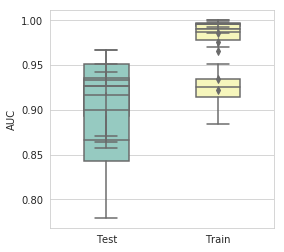

In [6]:
random.seed(12345)

start_time = time.time()

for n in [100,50,30,10]:
    trainlist = {}
    auroc_te = {}
    auroc_tr = {}
    ClasRep =  pd.DataFrame()
    TPredictions = {}
    tPredictions = {}
    inner_auc = {}
    Features = list()
    i=0
    sss =  StratifiedShuffleSplit(n_splits=16, test_size=0.2, random_state=12345)
    for train_index, test_index in sss.split(X_corr,y):
        X_train, X_test = X_corr.iloc[train_index], X_corr.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print(X_test.shape)
        i+=1
        trainlist[i] = list(X_train.index)

        ## CV inner
        
        features = list()  
        rf_te_roc_auc = list()
        rf_tr_roc_auc = list()
        acc = list()
        inner_score=list()

        ## inner split 

        sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=12345)
        rf = RandomForestClassifier(random_state=1)
        
        ## define search space
        
        space = dict()
        space['n_estimators'] = [50, 100, 250,300]
        space['max_depth'] = [4, 6, 8,10]
        search = GridSearchCV(rf, space, scoring='roc_auc', cv=sss, refit=True)
        search.fit(X_train,y_train)
        rf_cv = search.best_estimator_
        print(search.best_score_)
        inner_auc[i]=search.best_score_
        n_features_to_select = n  # Minimum number of features to consider
        rfe = RFE(estimator=rf_cv,n_features_to_select=n_features_to_select,step=10)
        rfe.fit(X_train, y_train)


        ## Extract selected features ##

        f = rfe.get_support(1)
        X_tr_rfe = X_train[X_train.columns[f]] 
        X_te_rfe = X_test[X_train.columns[f]] 

        ## fit again on whole training with selected features ##
        
        rf_rfe = rf_cv.fit(X_tr_rfe,y_train)
        yhat = rf_rfe.predict(X_te_rfe)
        yThat = rf_rfe.predict(X_tr_rfe)
        Features.append(list(X_te_rfe.columns))
        
        ## evaluate the model ##

        acc = accuracy_score(y_test, yhat)
        print("Accuracy: ",acc)
        
        ## AUROC ##
        rf_roc_auc = roc_auc_score(y_test,yhat)
        print("TestAUC: ",rf_roc_auc)
        auroc_te[i]= (rf_roc_auc) 
        rf_roc_auc = roc_auc_score(y_train,yThat)
        print("TrainAUC: ",rf_roc_auc)
        auroc_tr[i]= (rf_roc_auc) 
        
        ## Save Test Predictions
        data = {'Index': (y_test.index),
                'AET':y_test,
                    'Predictions':yhat, 
                   "Split":"Test",
                   "Iteration":i}
        Ptest = pd.DataFrame(data)
        tPredictions[i] = Ptest
        
        ## Save Train Predictions
        data = {'Index': (y_train.index),
                    'AET':y_train,
                        'Predictions':yThat, 
                       "Split":"Train",
                       "Iteration":i}
        Ptrain = pd.DataFrame(data)
        TPredictions[i] = Ptrain

        ## Scores ##
        cr = (classification_report(y_test, yhat,output_dict=True))
        cr = pd.DataFrame.from_dict(cr).T
        ClasRep = pd.concat([ClasRep,cr])
    
    path="OutputNCV/OuterNoGroupRFECV/RFE_CORR/nselect"+str(n)+"/"
    
    ## Save AUC ##
    AUROCt = pd.DataFrame.from_dict(auroc_te, orient='index')
    AUROCt.to_csv(path+"testAUC.csv")
    AUROCT = pd.DataFrame.from_dict(auroc_tr, orient='index')
    AUROCT.to_csv(path+"trainAUC.csv")
    
    ## Figure
    AUROCt["Split"] = "Test"
    AUROCT["Split"] = "Train"
    auc = pd.concat([AUROCt,AUROCT])

    plt.rcParams["figure.figsize"] = (4,4)
    sns.set_style("whitegrid")
    fig=sns.boxplot(data=auc,x='Split',y=0,palette="Set3",width=0.4)
    plt.xlabel('')
    plt.ylabel('AUC')
    plt.savefig(path+"TrTeAUC.png",dpi=450)
    
    
    ### Selected Features ###
    
    pd.DataFrame(Features).to_csv(path+"SelectedFeatures.csv")
    import itertools
    merged = list(itertools.chain(*Features))
    selected_uq_features = (set(merged))
    pd.DataFrame(selected_uq_features).to_csv(path+"SelectedUqFeatures.csv")

    #### Select features from auc > 0.7
    
    auc07 = list(auc[auc[0]>0.7].index)
    auc07 = [x - 1 for x in auc07]
    feats = pd.DataFrame(Features)
    feats_auc=pd.DataFrame()
    for n in auc07:
        a = (feats[feats.index==n])
        feats_auc = pd.concat([feats_auc,a])
    feats_auc.to_csv(path+"SelectedFeatures_auc07.csv")
    feats_auc = feats_auc.values.tolist()
    merged = list(itertools.chain(*feats_auc))
    selected_uq_features_auc07 = (set(merged))
    pd.DataFrame(selected_uq_features_auc07).to_csv(path+"SelectedUqFeatures_auc07.csv")


    ## Save Outer Classification Report ##
    ClasRep.to_csv(path+"ClassReport.csv")
    

    
print("--- %s seconds ---" % (time.time() - start_time))


#### Cross Validation with Selected Features

In [9]:
random.seed(12345)

for i in ["100","50","30","10"]:
    selected_uq_features = list(pd.read_csv("OutputNewNCV/OuterNoGroupRFECV/RFE_CORR/nselect"+str(i)+"/SelectedUqFeatures_auc07.csv")["0"])
    
    ### Selected Features from NCV
    X_sel = X_corr[selected_uq_features]
    Xval_sel = X_val[selected_uq_features]

    ClasRep =  pd.DataFrame()

    ### Fit on whole training data ## 
    ### Test on validation/hold out data set ##


    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=12345)
    rf = RandomForestClassifier(random_state=1)
    
    ## define search space
    space = dict()
    space['n_estimators'] = [50, 100,200, 250,300]
    space['max_depth'] = [4, 6, 8,10]
    search = GridSearchCV(rf, space, scoring='roc_auc', cv=sss, refit=True)
    search.fit(X_sel,y)
    cv_results = search.cv_results_
    rf_cv = search.best_estimator_
    yhat = rf_cv.predict(Xval_sel)
    probas_ = rf_cv.predict_proba(Xval_sel)
    yThat = rf_cv.predict(X_sel)

    ## Features Importance ##
    
    features = X_sel.columns
    importances = rf_cv.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_imp_RF = (pd.DataFrame(np.flipud([features[z] for z in indices])))
    feat_imp_RF['Importance'] = importances

    ## Feature Permutation 
    
    resultp = permutation_importance(rf_cv, Xval_sel, y_val, n_repeats=100, n_jobs=-1)
    perm_sorted_idx = resultp.importances_mean.argsort()
    permutations = pd.DataFrame({'Feature':Xval_sel.columns.values[perm_sorted_idx][::-1],'Mean':resultp.importances_mean[perm_sorted_idx][::-1],
                          'std':resultp.importances_std[perm_sorted_idx][::-1]})
    PermutResults = permutations

    ## evaluate the model ##
    
    print("Testing on validation set: ")
    acc = accuracy_score(y_val, yhat)
    print(acc)

    ## AUROC test ##
    
    rf_roc_auc = roc_auc_score(y_val,yhat)

    print("Test AUC"+str(rf_roc_auc))
    auroc_te = (rf_roc_auc) 

    ## AUROC train ##
    
    rf_roc_auc = roc_auc_score(y,yThat)
    print("Train AUC"+str(rf_roc_auc))
    auroc_tr = (rf_roc_auc) 

    ## Save Test Predictions
    
    data = {'Index': (y_val.index),
                'AET':y_val,
                    'Predictions':yhat, 
                   "Split":"Test",
                   "Iteration":i}
    Ptest = pd.DataFrame(data)
    tPredictions = Ptest
    
    ## Save Train Predictions
    
    data = {'Index': (y.index),
                    'AET':y,
                        'Predictions':yThat, 
                       "Split":"Train",
                       "Iteration":i}
    Ptrain = pd.DataFrame(data)
    TPredictions = Ptrain
    
    ## Scores ##
    
    cr = (classification_report(y_val, yhat,output_dict=True))
    cr = pd.DataFrame.from_dict(cr).T
    ClasRep = pd.concat([ClasRep,cr])

    path="OutputNewNCV/OuterNoGroupRFECV/RFE_CORR/nselect"+str(i)+"/Fall/"
    
    ## Save Feature Importance
    df = pd.DataFrame.from_dict(feat_imp_RF).sort_values(by=['Importance'],ascending=False)
#     df = df[df['Importance'].cumsum() < 0.8]
#     df.to_csv(path+"FeatureImportance.csv")

   
    ## Save Permutation Importance
    
#     PermutResults.to_csv(path+"PermutResults.csv")

    ## Save Classification Report
    
#     ClasRep.to_csv(path+"ClasRep.csv")

    ## Save AUC
    
#     pd.DataFrame([auroc_te]).to_csv(path+"AUROCtest.csv")
#     pd.DataFrame([auroc_tr]).to_csv(path+"AUROCtrain.csv")
    
     
    ## Save Individual Predictions
   
     #pd.DataFrame(TPredictions).to_csv(path+"TPredictions.csv")
#     pd.DataFrame(tPredictions).to_csv(path+"tPredictions.csv")
    

Testing on validation set: 
0.86
Test AUC0.8420138888888888
Train AUC0.9968354430379747
Testing on validation set: 
0.86
Test AUC0.8298611111111112
Train AUC0.9515358059661858
Testing on validation set: 
0.88
Test AUC0.8576388888888888
Train AUC0.9870098256174205
Testing on validation set: 
0.88
Test AUC0.8576388888888888
Train AUC0.9493670886075949


### Further reduce number of features

In [9]:
## half features

random.seed(12345)

for i in ["100","50","30","10"]:
    
    df = pd.read_csv("OutputNCV/OuterNoGroupRFECV/RFE_CORR/nselect"+str(i)+"/Fall/FeatureImportance.csv")
    df = df[df['Importance'].cumsum() < 0.5]

    f = (round(df.shape[0]))
    print(f)

    X_seln = X_corr[list(df.iloc[0:f,]["0"])]
    Xval_seln = X_val[list(df.iloc[0:f,]["0"])]

    random.seed(12345)

    ClasRep =  pd.DataFrame()

    ### Fit on whole training data ## 
    ### Test on validation/hold out data set ##


    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=12345)
    rf = RandomForestClassifier(random_state=1)
    #         # define search space
    space = dict()
    space['n_estimators'] = [50, 100,200, 250,300]
    space['max_depth'] = [4, 6, 8,10]
    search = GridSearchCV(rf, space, scoring='roc_auc', cv=sss, refit=True)
    search.fit(X_seln,y)
    cv_results = search.cv_results_
    rf_cv = search.best_estimator_
    yhat = rf_cv.predict(Xval_seln)
    probas_ = rf_cv.predict_proba(Xval_seln)
    yThat = rf_cv.predict(X_seln)

    ## Features Importance ##
    features = X_seln.columns
    # Fmodels[i] = rf_rfe
    importances = rf_cv.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_imp_RF = (pd.DataFrame(np.flipud([features[z] for z in indices])))
    feat_imp_RF['Importance'] = importances

        ## Feature Permutation 
    resultp = permutation_importance(rf_cv, Xval_seln, y_val, n_repeats=100, n_jobs=-1)
    perm_sorted_idx = resultp.importances_mean.argsort()
    permutations = pd.DataFrame({'Feature':Xval_seln.columns.values[perm_sorted_idx][::-1],'Mean':resultp.importances_mean[perm_sorted_idx][::-1],
                          'std':resultp.importances_std[perm_sorted_idx][::-1]})
    PermutResults = permutations

    ## evaluate the model ##

    acc = accuracy_score(y_val, yhat)
    print(acc)

    ## AUROC test ##
    rf_roc_auc = roc_auc_score(y_val,yhat)

    print("Test AUC"+str(rf_roc_auc))
    auroc_te = (rf_roc_auc) 

    ## AUROC train ##
    rf_roc_auc = roc_auc_score(y,yThat)
    print("Train AUC"+str(rf_roc_auc))
    auroc_tr = (rf_roc_auc) 

    ## Save Test Predictions
    data = {'Index': (y_val.index),
                'AET':y_val,
                    'Predictions':yhat, 
                   "Split":"Test",
                   "Iteration":i}
    Ptest = pd.DataFrame(data)
    tPredictions = Ptest
        ## Save Train Predictions
    data = {'Index': (y.index),
                    'AET':y,
                        'Predictions':yThat, 
                       "Split":"Train",
                       "Iteration":i}
    Ptrain = pd.DataFrame(data)
    TPredictions = Ptrain

    ## Scores ##
    cr = (classification_report(y_val, yhat,output_dict=True))
    cr = pd.DataFrame.from_dict(cr).T
    ClasRep = pd.concat([ClasRep,cr])

    path="OutputNewNCV/OuterNoGroupRFECV/RFE_CORR/nselect"+str(i)+"/Fall2/"
    ## Save Feature Importance
    df = pd.DataFrame.from_dict(feat_imp_RF).sort_values(by=['Importance'],ascending=False)
#     df = df[df['Importance'].cumsum() < 0.8]
    df.to_csv(path+"FeatureImportance.csv")

    ## Save Permutation Importance
    PermutResults.to_csv(path+"PermutResults.csv")

    ## Save Classification Report
    ClasRep.to_csv(path+"ClasRep.csv")

    ## Save AUC
    pd.DataFrame([auroc_te]).to_csv(path+"AUROCtest.csv")
    pd.DataFrame([auroc_tr]).to_csv(path+"AUROCtrain.csv")
    
    ## Save Individual Predictions
    pd.DataFrame(TPredictions).to_csv(path+"TPredictions.csv")
    pd.DataFrame(tPredictions).to_csv(path+"tPredictions.csv")

78
0.82
Test AUC0.7864583333333333
Train AUC0.9662742320970169
52
0.84
Test AUC0.8020833333333333
Train AUC0.9293839072320086
33
0.84
Test AUC0.8142361111111112
Train AUC0.9518677525006639
14
0.9
Test AUC0.8854166666666667
Train AUC0.930888731521643


In [7]:
random.seed(12345)

for i in ["100","50","30","10"]:
    
    df = pd.read_csv("OutputNCV/OuterNoGroupRFECV/RFE_CORR/nselect"+str(i)+"/Fall2/FeatureImportance.csv")
    df = df[df['Importance'].cumsum() < 0.8]

    f = (round(df.shape[0]))
    print(f)

    X_seln = X_corr[list(df.iloc[0:f,]["0"])]
    Xval_seln = X_val[list(df.iloc[0:f,]["0"])]

    random.seed(12345)

    ClasRep =  pd.DataFrame()

    ### Fit on whole training data ## 
    ### Test on validation/hold out data set ##


    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=12345)
    rf = RandomForestClassifier(random_state=1)
    
    ## define search space
    
    space = dict()
    space['n_estimators'] = [50, 100,200, 250,300]
    space['max_depth'] = [4, 6, 8,10]
    search = GridSearchCV(rf, space, scoring='roc_auc', cv=sss, refit=True)
    search.fit(X_seln,y)
    cv_results = search.cv_results_
    rf_cv = search.best_estimator_
    yhat = rf_cv.predict(Xval_seln)
    probas_ = rf_cv.predict_proba(Xval_seln)
    yThat = rf_cv.predict(X_seln)

    ## Features Importance ##

    features = X_seln.columns
    importances = rf_cv.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_imp_RF = (pd.DataFrame(np.flipud([features[z] for z in indices])))
    feat_imp_RF['Importance'] = importances

    ## Feature Permutation 
    
    resultp = permutation_importance(rf_cv, Xval_seln, y_val, n_repeats=100, n_jobs=-1)
    perm_sorted_idx = resultp.importances_mean.argsort()
    permutations = pd.DataFrame({'Feature':Xval_seln.columns.values[perm_sorted_idx][::-1],'Mean':resultp.importances_mean[perm_sorted_idx][::-1],
                          'std':resultp.importances_std[perm_sorted_idx][::-1]})
    PermutResults = permutations

    ## evaluate the model ##

    acc = accuracy_score(y_val, yhat)
    print(acc)

    ## AUROC test ##
    
    rf_roc_auc = roc_auc_score(y_val,yhat)

    print("Test AUC"+str(rf_roc_auc))
    auroc_te = (rf_roc_auc) 

    ## AUROC train ##
    
    rf_roc_auc = roc_auc_score(y,yThat)
    print("Train AUC"+str(rf_roc_auc))
    auroc_tr = (rf_roc_auc) 

    ## Save Test Predictions
    
    data = {'Index': (y_val.index),
                'AET':y_val,
                    'Predictions':yhat, 
                   "Split":"Test",
                   "Iteration":i}
    Ptest = pd.DataFrame(data)
    tPredictions = Ptest
    ## Save Train Predictions
    
    data = {'Index': (y.index),
                    'AET':y,
                        'Predictions':yThat, 
                       "Split":"Train",
                       "Iteration":i}
    Ptrain = pd.DataFrame(data)
    TPredictions = Ptrain

    ## Scores ##
    
    cr = (classification_report(y_val, yhat,output_dict=True))
    cr = pd.DataFrame.from_dict(cr).T
    ClasRep = pd.concat([ClasRep,cr])

    path="OutputNewNCV/OuterNoGroupRFECV/RFE_CORR/nselect"+str(i)+"/Fall3/"
    
    ## Save Feature Importance
    
    df = pd.DataFrame.from_dict(feat_imp_RF).sort_values(by=['Importance'],ascending=False)
#     df = df[df['Importance'].cumsum() < 0.8]
#     df.to_csv(path+"FeatureImportance.csv")

#     ## Save Permutation Importance
    
#     PermutResults.to_csv(path+"PermutResults.csv")

#     ## Save Classification Report
   
#     ClasRep.to_csv(path+"ClasRep.csv")

#     ## Save AUC
    
#     pd.DataFrame([auroc_te]).to_csv(path+"AUROCtest.csv")
#     pd.DataFrame([auroc_tr]).to_csv(path+"AUROCtrain.csv")
    
#     ## Save Individual Predictions
    
#     pd.DataFrame(TPredictions).to_csv(path+"TPredictions.csv")
#     pd.DataFrame(tPredictions).to_csv(path+"tPredictions.csv")

101
0.84
Test AUC0.8142361111111112
Train AUC0.9968354430379747
73
0.86
Test AUC0.8177083333333333
Train AUC0.9293839072320086
45
0.86
Test AUC0.8298611111111112
Train AUC0.9599451181729662
18
0.9
Test AUC0.8854166666666667
Train AUC0.9480393024696822
